# Problem Defination

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

# Import dependencies

In [1]:
import findspark
findspark.init()
import pyspark as ps

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
# from pyspark.sql.window import Window
# from pyspark.sql.functions import ntile
from pyspark.sql.functions import rand 
from pyspark.sql.functions import lower
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col, concat_ws

from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, ArrayType, StringType

import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer

In [3]:
spark = SparkSession.builder.appName('pySparkSetup').getOrCreate()

In [4]:
spark

# Load dataset

### Content
It contains the following 6 fields:

`target`: the polarity of the tweet (0 = negative, 4 = positive)

`ids`: The id of the tweet ( 2087)

`date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

`flag`: The query (lyx). If there is no query, then this value is NO_QUERY.

`user`: the user that tweeted (robotickilldozr)

`text`: the text of the tweet (Lyx is cool)

In [5]:
# Using header record for the column names
df = spark.read.option("header",False) \
              .csv('TwitterReviews.csv')
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



In [6]:
from functools import reduce
from past.builtins import xrange

oldColumns = df.schema.names
header_names = ['target','ids','data','flag','user', 'text']
oldColumns

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5']

In [7]:
df = reduce(lambda df, idx: df.withColumnRenamed(oldColumns[idx], header_names[idx]), xrange(len(oldColumns)), df)
df.printSchema()
df.show(5)

root
 |-- target: string (nullable = true)
 |-- ids: string (nullable = true)
 |-- data: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                data|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+----------------

# Cleaning Data

## Handling Nulls

In [8]:
print('Data shape before dropping Nulls:{:,} '.format(df.count()))
df2 = df.dropna()
print('Data shape after dropping Nulls:{:,} '.format(df2.count()))

Data shape before dropping Nulls:1,604,349 
Data shape after dropping Nulls:1,572,846 


## Remove irrelative rows

In [9]:
df2.select("target").distinct().show()

+--------------------+
|              target|
+--------------------+
|                   0|
|                   4|
|         !ᕙr��B"|
|�:��?�^��H�T�qi�B...|
+--------------------+



In [10]:
df3 = df2.filter((df.target == "0")|(df.target == "4"))
print('Data shape after dropping unspecified data :{:,} '.format(df3.count()))

Data shape after dropping unspecified data :1,572,595 


 ## Droppe Un-wanted columns

In [11]:
df4 = df3['target','text']
df4.show(4,False)

+------+-------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                               |
+------+-------------------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0     |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|0     |my whole body feels itchy and like its on fire                                                                     |
+------+-------------------------------------------------------------------------------------------------------------------+


## Convert target columns from (0, 4) to (0, 1)

In [12]:
df4.select("target").distinct().show()

+------+
|target|
+------+
|     0|
|     4|
+------+



In [13]:
df5 = df4.withColumn('target',regexp_replace(df4.target,'4','1'))
df5.show(5, False)

+------+-------------------------------------------------------------------------------------------------------------------+
|target|text                                                                                                               |
+------+-------------------------------------------------------------------------------------------------------------------+
|0     |@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0     |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|0     |my whole body feels itchy and like its on fire                                                                     |
|0     |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |


In [14]:
df5.select("target").distinct().show()

+------+
|target|
+------+
|     0|
|     1|
+------+



## Check data balancing

In [15]:
df_neg = df5.filter((df5.target == "0"))
df_pos = df5.filter((df5.target == "1"))

print("Positave Review Percentage : {:.2f}%".format(df_pos.count()*100/df5.count() ))
print("Negative Review Percentage :{:.2f}%".format(df_neg.count()*100/df5.count() ))


Positave Review Percentage : 49.13%
Negative Review Percentage :50.87%


## Remove irrelative words

In [16]:
df6 = df5.toPandas()
df6.count()

target    1572595
text      1572595
dtype: int64

In [17]:
"""
Regex pattern to clean dataset
"""
# remove the user mentions
mentions = r'@[A-Za-z0-9_]+'
print(' Mention pattern : \n','-'*30,'\n', mentions,'\n\n')

# remove links
links1 = r'https?://[^ ]+'
links2 = r'www.[^ ]+'

# Neglect stop words
negations_dic = {"that's":"that is","this's": "this is",
                 "it's":"it is","isn't":"is not", "aren't":"are not", "wasn't":"was not",
                 "weren't":"were not","i'm":"i am","we're":"we are", "doesn't":"does not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}


# links pattern
links = r'|'.join((links1, links2))
print(' Links pattern : \n','-'*30,'\n', links,'\n\n')

# mapping words pattern
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
print(' Words Mapping pattern: \n','-'*30,'\n', neg_pattern)


 Mention pattern : 
 ------------------------------ 
 @[A-Za-z0-9_]+ 


 Links pattern : 
 ------------------------------ 
 https?://[^ ]+|www.[^ ]+ 


 Words Mapping pattern: 
 ------------------------------ 
 re.compile("\\b(that's|this's|it's|isn't|aren't|wasn't|weren't|i'm|we're|doesn't|haven't|hasn't|hadn't|won't|wouldn't|don't|didn't|can't|couldn't|shouldn't|mightn't|mustn't)\\b")


In [18]:
def tweet_cleaner(text):
    """
    Data cleaning function to solve some problems in the dataset: 
        1. Remove mention (eny text starts by `@`).
        2. Remove `url` links starts with `http`. 
        3. Remove `url` links starts with `www`.
        4. Remove special characters includes punctuations (such as “=”, “_”, “~”, etc).
        5. Negation words are split into two parts, and the `t`. This makes words like “can’t” end up as same as “can”.
    """
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        """
        \ufffd is the replacement character in unicode, 
        it is used when we try to read a code that has no representation in unicode. 
        """
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    
    stripped = re.sub(mentions, '', bom_removed)
    stripped = re.sub(links, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    # remove special characters, numbers and punctuations 
    letters_only = re.sub("[^a-z]", " ", neg_handled)
    
    # now we need to remove any single char 
    tok = WordPunctTokenizer()
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]

    return (" ".join(words)).strip()

In [19]:
print("Cleaning and parsing the tweets...\n")

data = df6['text'].values
clean_tweet_texts = []

for index in range(data.shape[0]):
    clean_tweet_texts.append(tweet_cleaner(data[index]))

print("Done Cleaning and parsing the tweets.\n")

Cleaning and parsing the tweets...

Done Cleaning and parsing the tweets.



In [20]:
# store the list data in dataframe
df7 = pd.DataFrame(clean_tweet_texts,columns=['text'])
df7['target'] = df6.target
df7.head()

,text,target
0,awww that is bummer you shoulda got david carr...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it is not behaving at all am mad why am her...,0


# Data Preprocessing

## Convert pandas to pyspark datafram to make the model

In [21]:
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df7) 
sparkDF.printSchema()
sparkDF.show(5, False)

root
 |-- text: string (nullable = true)
 |-- target: string (nullable = true)

+---------------------------------------------------------------------------------------------------------+------+
|text                                                                                                     |target|
+---------------------------------------------------------------------------------------------------------+------+
|awww that is bummer you shoulda got david carr of third day to do it                                     |0     |
|is upset that he can not update his facebook by texting it and might cry as result school today also blah|0     |
|dived many times for the ball managed to save the rest go out of bounds                                  |0     |
|my whole body feels itchy and like its on fire                                                           |0     |
|no it is not behaving at all am mad why am here because can not see you all over there                   |0     |


## Remove stop words

In [22]:
# import all the stop words from gensim 
import gensim
from gensim.parsing.preprocessing import STOPWORDS

stops = list(STOPWORDS)
stops.append('im')
stops

['else',
 'full',
 'off',
 'hereby',
 'fill',
 'seeming',
 'it',
 'amount',
 'too',
 'twelve',
 'call',
 'into',
 'but',
 're',
 'being',
 'nine',
 'enough',
 'her',
 'yours',
 'seems',
 'whom',
 'only',
 'myself',
 'are',
 'namely',
 'after',
 'both',
 'such',
 'very',
 'really',
 'a',
 'top',
 'have',
 'their',
 'nowhere',
 'from',
 'should',
 'doing',
 'there',
 'again',
 'our',
 'whole',
 'whereas',
 'former',
 'above',
 'no',
 'throughout',
 'mostly',
 'wherever',
 'themselves',
 'somehow',
 'two',
 'was',
 'also',
 'more',
 'he',
 'out',
 'cry',
 'yourself',
 'eleven',
 'whither',
 'system',
 'twenty',
 'through',
 'noone',
 'back',
 'over',
 'with',
 'everyone',
 'i',
 'an',
 'someone',
 'unless',
 'the',
 'to',
 'next',
 'four',
 'moreover',
 'once',
 'hers',
 'something',
 'five',
 'toward',
 'nothing',
 'still',
 'another',
 'sometime',
 'latter',
 'each',
 'within',
 'between',
 'found',
 'quite',
 'name',
 'became',
 'done',
 'other',
 'same',
 'fifteen',
 'take',
 'without

In [23]:
print("Removing Stop Words ...\n")

lemmatizer = WordNetLemmatizer()

tokenizerUDF = udf(lambda x: x.split(' '), ArrayType(StringType()))
removeStopWordsUDF = udf(lambda x: [w for w in x if not (w in stops) ], ArrayType(StringType()))   
lemmaUDF = udf(lambda x: [lemmatizer.lemmatize(s) for s in x], ArrayType(StringType()))

sparkDF_copy = sparkDF.select('*')
sparkDF_copy = sparkDF_copy.withColumn('text', tokenizerUDF(sparkDF_copy.text))
sparkDF_copy = sparkDF_copy.withColumn('text', removeStopWordsUDF(sparkDF_copy.text))
sparkDF_copy = sparkDF_copy.withColumn('text', lemmaUDF(sparkDF_copy.text))

print("Done removing Stop Words ...\n")

Removing Stop Words ...

Done removing Stop Words ...



In [24]:
sparkDF_copy.show(5)

+--------------------+------+
|                text|target|
+--------------------+------+
|[awww, bummer, sh...|     0|
|[upset, update, f...|     0|
|[dived, time, bal...|     0|
|[body, feel, itch...|     0|
|     [behaving, mad]|     0|
+--------------------+------+
only showing top 5 rows



## Draw the Word Cloud graph
It is a visualization technique for text data wherein each word is picturized with its importance in the context or its frequency. The word size is proportional to the frequency of this word.

In [25]:
from wordcloud import WordCloud

def wordCloud(text_df):
    """
    Function to draw wordcloud. Pandas dataframe is only allowed
    """
    list_ = []
    for t in text_df["text"]:
        list_.append(' '.join(t))
    text = pd.Series(list_).str.cat(sep=' ')
    word_cloud = WordCloud(width=1600, height=800,max_font_size=200).generate(text)
    
    plt.figure(figsize=(12,10))
    
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [26]:
# convert to pandas to be able to drwa the cloud words
neg_tweets = sparkDF_copy.filter(sparkDF_copy.target == 0).toPandas()
pos_tweets = sparkDF_copy.filter(sparkDF_copy.target == 1).toPandas()

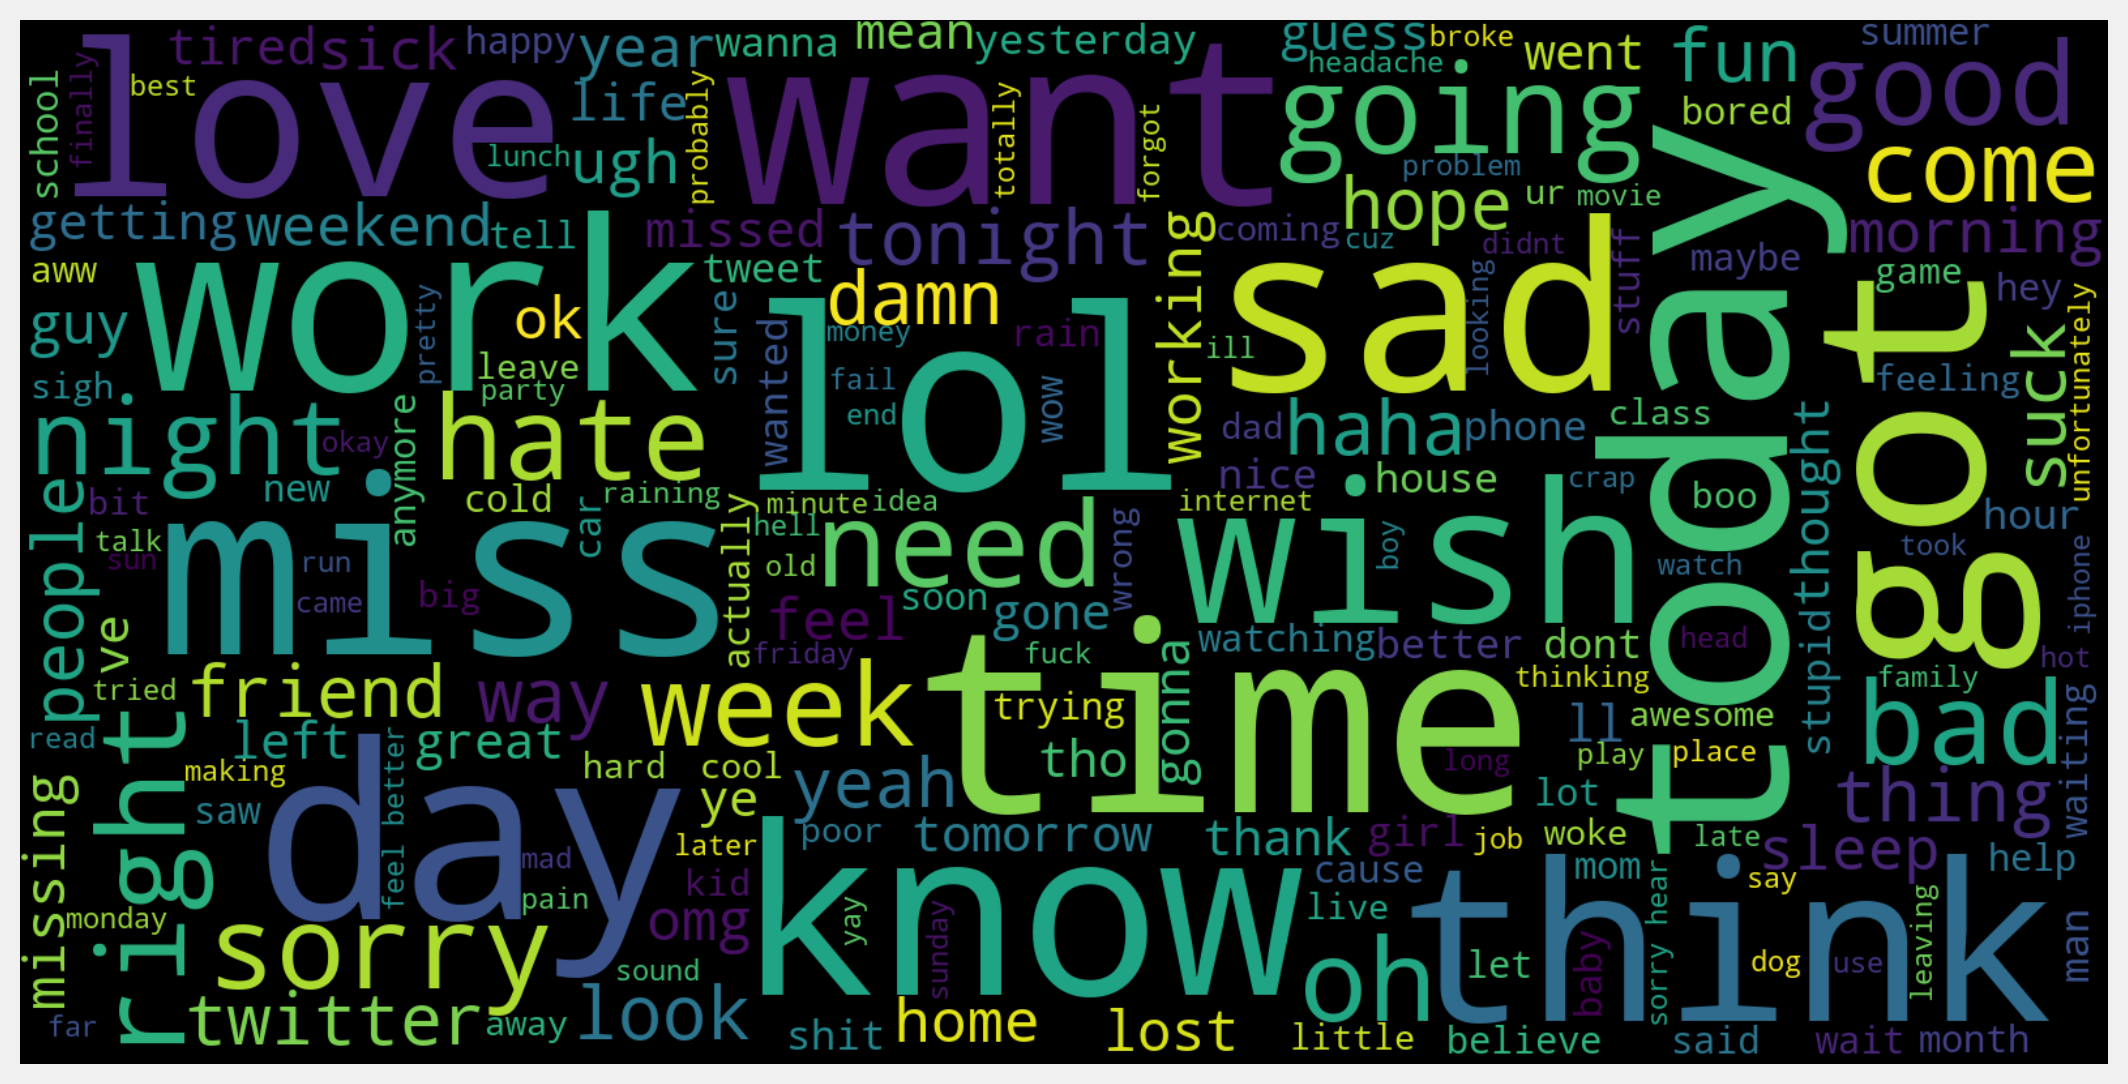

In [27]:
wordCloud(neg_tweets)

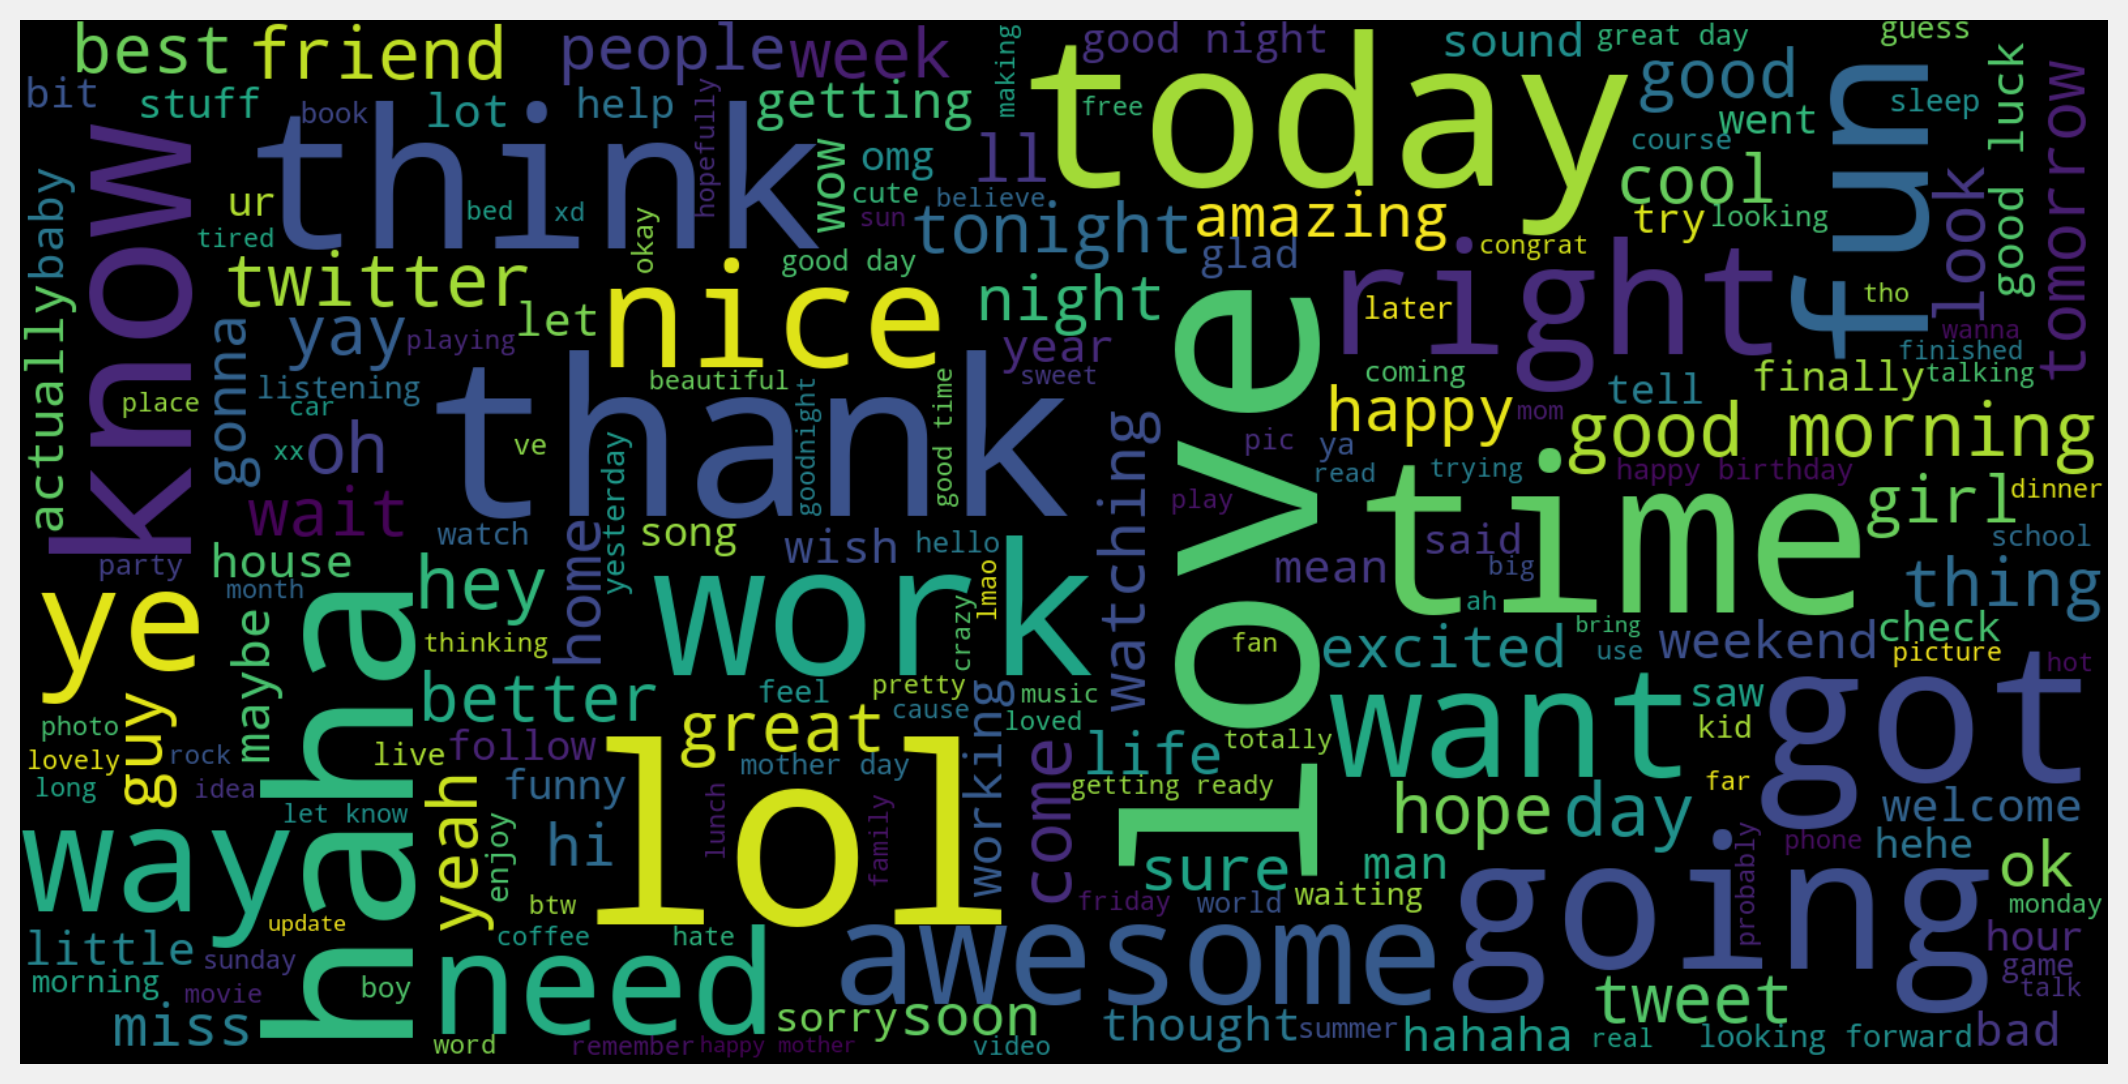

In [28]:
wordCloud(pos_tweets)

# Partitioning Data 

splitting the data into train test split 

In [29]:
def split_by_row_index(df): 
    # shuffle the data frame before the split operation 
    
    shuffled_df = df.orderBy(rand())
    
    #calculate the data into 99% train and 1% test data 
    test_size=int(shuffled_df.count()*0.1)
    train_size=shuffled_df.count()-test_size
    
    train_set, val_set = shuffled_df.limit(train_size), shuffled_df.limit(test_size)

    return train_set, val_set

## Feature Extraction Using TF-IDF

In [31]:
hashtf = HashingTF(numFeatures=2**16, inputCol="text", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) 
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

#Creat Pipline
pipeline = Pipeline(stages=[hashtf, idf, label_stringIdx])

# Apply pipline to the train sets
pipelineFit = pipeline.fit(sparkDF_copy)
sparkDF_copy_tf_idf = pipelineFit.transform(sparkDF_copy)


# Call the function for each entry of the data frame
train_tf_idf, val_tf_idf = split_by_row_index(sparkDF_copy_tf_idf);


In [32]:
# train_tf_idf

In [33]:
# val_tf_idf.show(2)

In [34]:
print("No. of training set : {:,}".format(train_tf_idf.count()))
print("No. of training set : {:,}".format(val_tf_idf.count()))

No. of training set : 1,415,336
No. of training set : 157,259


## Feature Extraction Using CountVectorizer

In [36]:
%%time
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(vocabSize=2**16, inputCol="text", outputCol='features')
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

#Creat Pipline
pipeline = Pipeline(stages=[cv, label_stringIdx])

# Apply pipline to the train sets
pipelineFit = pipeline.fit(sparkDF_copy)
sparkDF_copy_cv = pipelineFit.transform(sparkDF_copy)


# Call the function for each entry of the data frame
train_cv, val_cv = split_by_row_index(sparkDF_copy_cv);

Wall time: 54.1 s


In [37]:
print("No. of training set : {:,}".format(train_cv.count()))
print("No. of training set : {:,}".format(val_cv.count()))

No. of training set : 1,415,336
No. of training set : 157,259


In [38]:
# train_cv.show(5)
# val_cv.show(5)

# Creat Logistic Regression Model

### Build logistic regression model 

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=100)
lr

LogisticRegression_3efa0c442045

### Train logistic regression model  on TF-IDF Features

In [40]:
%%time
lrModel_tf = lr.fit(train_tf_idf)
pred_tf = lrModel_tf.transform(val_tf_idf)

Wall time: 1min 7s


### Validate logistic regression model  on TF-IDF Features

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


eval_accuracy = MulticlassClassificationEvaluator( metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision")
eval_recall = MulticlassClassificationEvaluator( metricName="weightedRecall")
eval_f1 = MulticlassClassificationEvaluator( metricName="f1")
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

accuracy = eval_accuracy.evaluate(pred_tf)
precision = eval_precision.evaluate(pred_tf)
recall = eval_recall.evaluate(pred_tf)
f1score = eval_f1.evaluate(pred_tf)
AUC = evaluator.evaluate(pred_tf)

In [42]:
print('accuracy of LR on TF-IDF Features: ',accuracy)
print('precision of LR on TF-IDF Features: ',precision)
print('recall of LR on TF-IDF Features: ',recall)
print('f1 score of LR on TF-IDF Features: ',f1score)
print('AUC of LR on TF-IDF Features: ',evaluator.evaluate(pred_tf))

accuracy of LR on TF-IDF Features:  0.7825561653069141
precision of LR on TF-IDF Features:  0.783192481017184
recall of LR on TF-IDF Features:  0.7825561653069141
f1 score of LR on TF-IDF Features:  0.7825405199959397
AUC of LR on TF-IDF Features:  0.8608015211038709


### Plot ROC Curve

In [43]:
from pyspark.ml.classification import FMClassificationTrainingSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, records):
        points = []
        for record in records.collect():
            points += [(float(record._1()), float(record._2()))]
        return points

    def get_curve(self, method):
        points = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(points)

In [44]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotROC(model, predictions, roc_auc):
    predictions = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(predictions).get_curve('roc')
    fpr = [x[0] for x in points]
    tpr = [x[1] for x in points]
    plt.plot(fpr, tpr, label = f'{model.__class__.__name__} (AUC = {round(roc_auc, 2)})')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

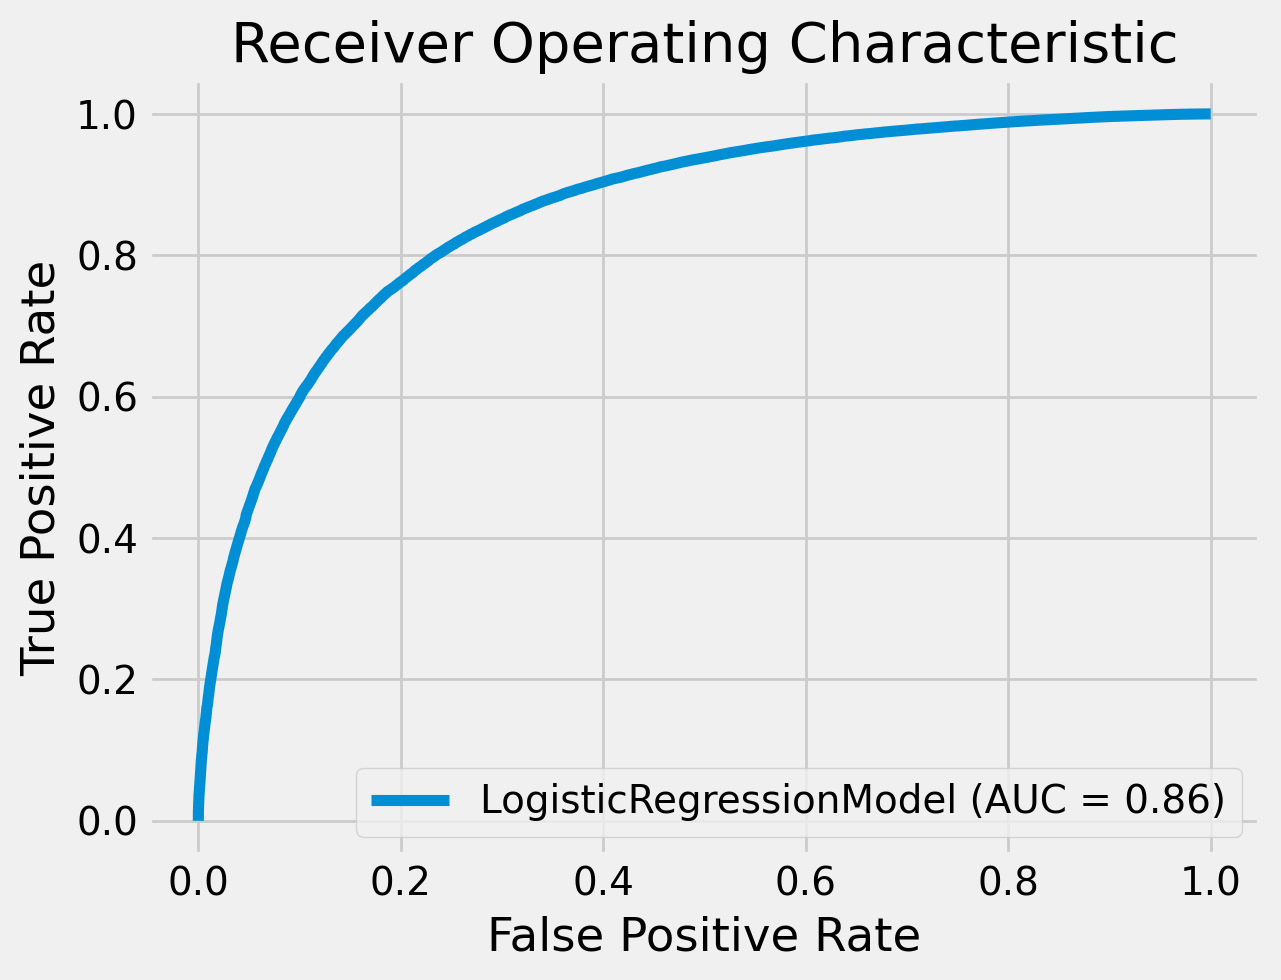

In [45]:
AUC = evaluator.evaluate(pred_tf)
plotROC(lrModel_tf, pred_tf, AUC)

### Train Logistic Regression on CountVectorizer Features

In [46]:
%%time
lrModel_cv = lr.fit(train_cv)
pred_cv = lrModel_cv.transform(val_cv)

Wall time: 1min 11s


### Validate Logistic Regression on CountVectorizer Features

In [47]:
accuracy_cv = eval_accuracy.evaluate(pred_cv)
precision_cv = eval_precision.evaluate(pred_cv)
recall_cv = eval_recall.evaluate(pred_cv)
f1score_cv = eval_f1.evaluate(pred_cv)
AUC_cv = evaluator.evaluate(pred_cv)

In [48]:
print('accuracy of LR on CountVectorizer Features: ',accuracy_cv)
print('precision of LR on CountVectorizer Features: ',precision_cv)
print('recall of LR on CountVectorizer Features: ',recall_cv)
print('f1 score of LR on CountVectorizer Features: ',f1score_cv)
print('AUC of LR on CountVectorizer Features: ',AUC_cv)

accuracy of LR on CountVectorizer Features:  0.7928385656782759
precision of LR on CountVectorizer Features:  0.7934527407962576
recall of LR on CountVectorizer Features:  0.7928385656782759
f1 score of LR on CountVectorizer Features:  0.7928204552458676
AUC of LR on CountVectorizer Features:  0.8727237806067527


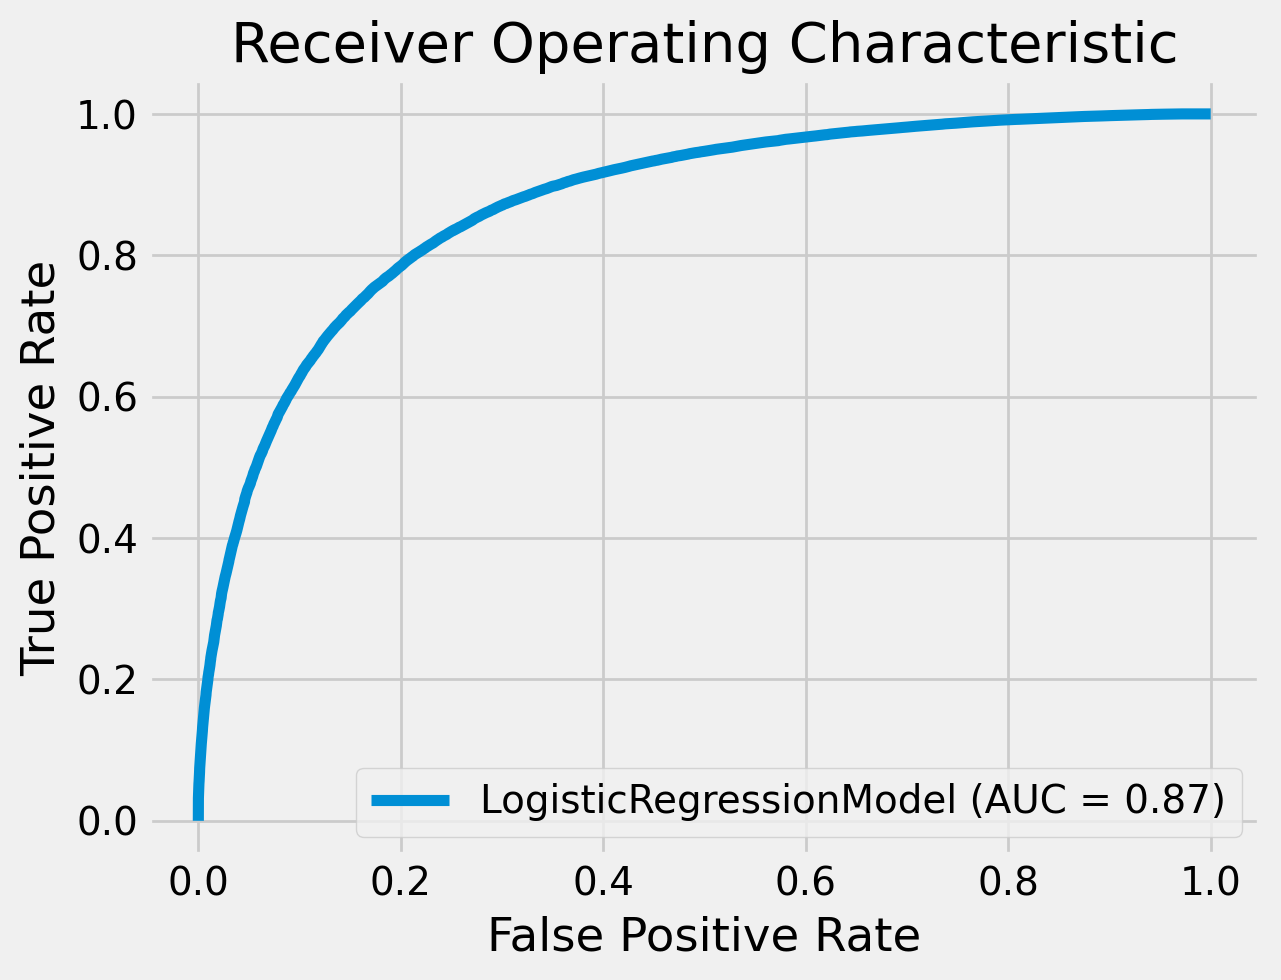

In [49]:
plotROC(lrModel_cv, pred_cv, AUC_cv)

## Create Naive Bayes Model 

### Build Naive Bayes model

In [50]:
from pyspark.ml.classification import NaiveBayes
NB = NaiveBayes(smoothing=1)
NB

NaiveBayes_ec2e16b94256

### Train Naive Bayes model  on TF-IDF Features

In [51]:
%%time
NB_tf_idf = NB.fit(train_tf_idf)
pred_nv_tf = NB_tf_idf.transform(val_tf_idf)

Wall time: 43 s


### Validate Naive Bayes model  on TF-IDF Features

In [52]:
accuracy_nv_tf = eval_accuracy.evaluate(pred_nv_tf)
precision_nv_tf = eval_precision.evaluate(pred_nv_tf)
recall_nv_tf = eval_recall.evaluate(pred_nv_tf)
f1score_nv_tf = eval_f1.evaluate(pred_nv_tf)
AUC_nv_tf = evaluator.evaluate(pred_nv_tf)

In [53]:
print('accuracy of NB on TF-IDF Features: ',accuracy_nv_tf)
print('precision of NB on TF-IDF Features: ',precision_nv_tf)
print('recall of NB on TF-IDF Features: ',recall_nv_tf)
print('f1 score of NB on TF-IDF Features: ',f1score_nv_tf)
print('AUC of NB on TF-IDF Features: ',AUC_nv_tf)

accuracy of NB on TF-IDF Features:  0.762531874169364
precision of NB on TF-IDF Features:  0.7625415190759881
recall of NB on TF-IDF Features:  0.7625318741693639
f1 score of NB on TF-IDF Features:  0.762535867258305
AUC of NB on TF-IDF Features:  0.51983053645526


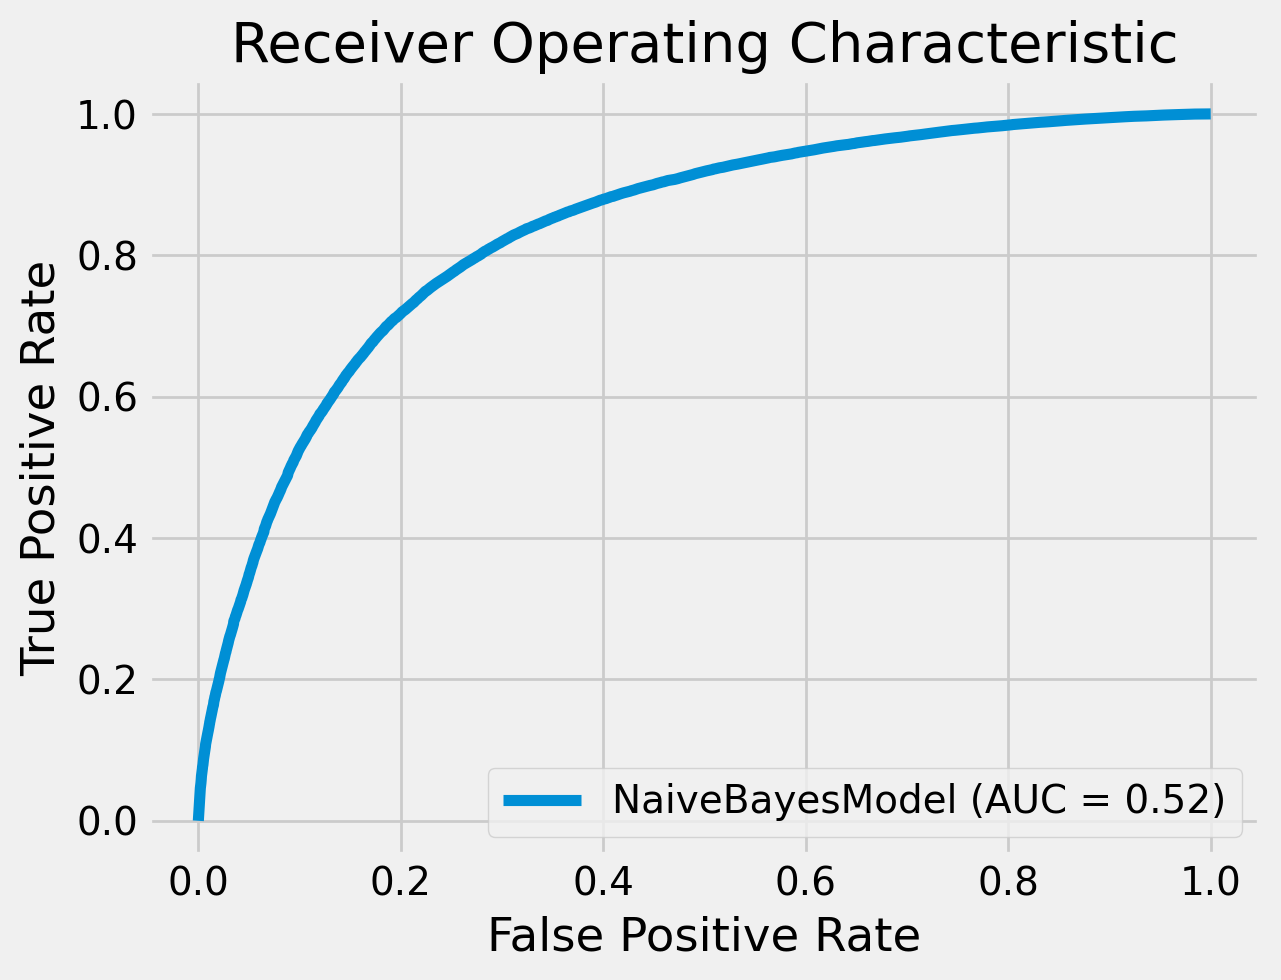

In [54]:
plotROC(NB_tf_idf, pred_nv_tf, AUC_nv_tf)

### Train Naive Bayes on CountVectorizer features

In [55]:
%%time

NB_cv = NB.fit(train_cv)
pred_nv_cv = NB_cv.transform(val_cv)

Wall time: 42.6 s


### validate Naive Bayes on CountVectorizer features

In [56]:
accuracy_nv_cv = eval_accuracy.evaluate(pred_nv_cv)
precision_nv_cv = eval_precision.evaluate(pred_nv_cv)
recall_nv_cv = eval_recall.evaluate(pred_nv_cv)
f1score_nv_cv = eval_f1.evaluate(pred_nv_cv)
AUC_nv_cv = evaluator.evaluate(pred_nv_cv)

In [57]:
print('accuracy of NB on CountVectorizer Features: ',accuracy_nv_cv)
print('precision of NB on CountVectorizer Features: ',precision_nv_cv)
print('recall of NB on CountVectorizer Features: ',recall_nv_cv)
print('f1 score of NB on CountVectorizer Features: ',f1score_nv_cv)
print('AUC of NB on CountVectorizer Features: ',AUC_nv_cv)

accuracy of NB on CountVectorizer Features:  0.7766741490153187
precision of NB on CountVectorizer Features:  0.7766756924018599
recall of NB on CountVectorizer Features:  0.7766741490153186
f1 score of NB on CountVectorizer Features:  0.7766406728485726
AUC of NB on CountVectorizer Features:  0.530728874222295


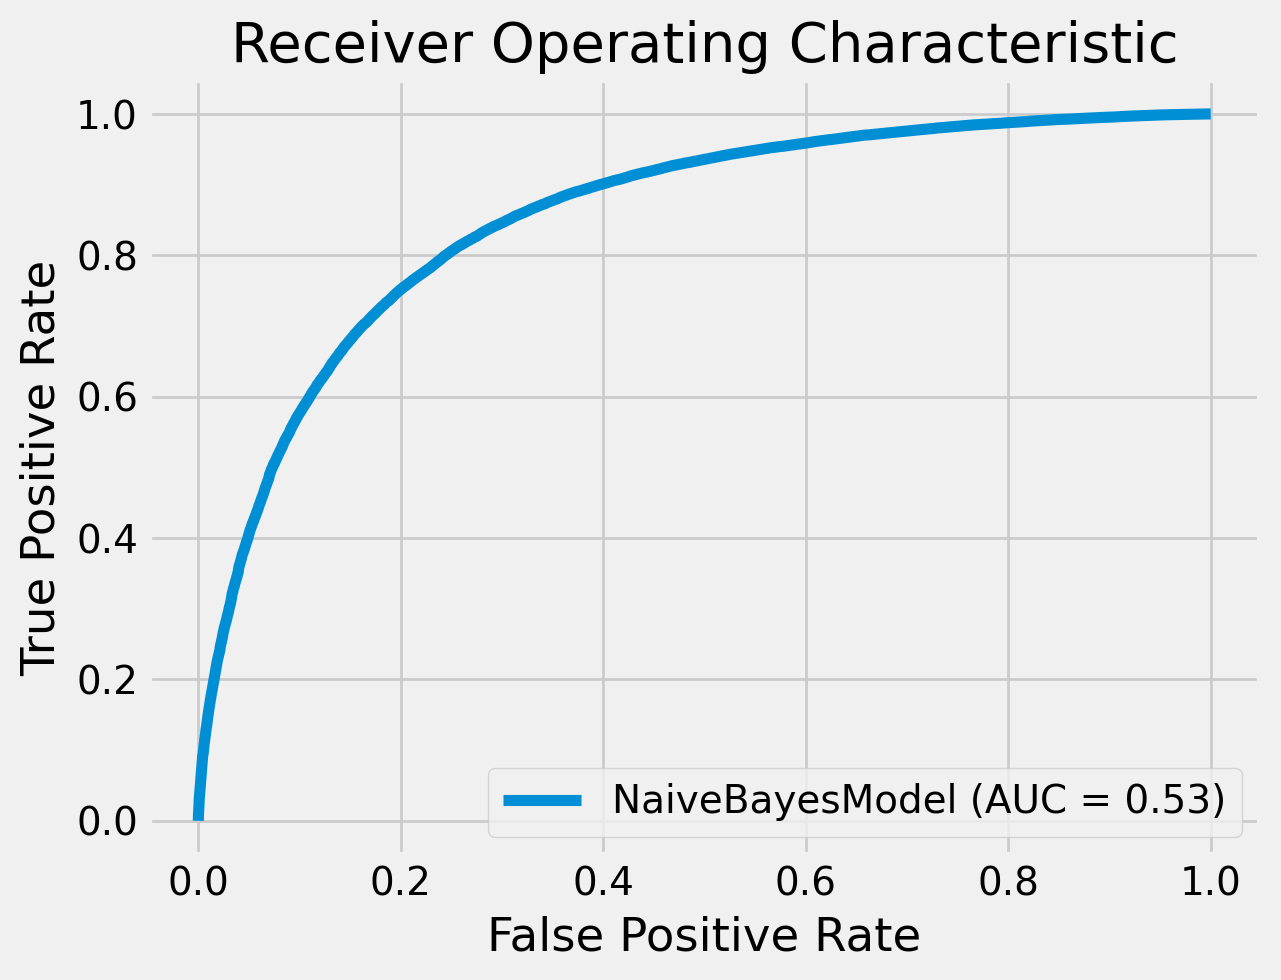

In [58]:
plotROC(NB_cv, pred_nv_cv, AUC_nv_cv)

## Creat Decision Tree Model

### Build DecisionTreeClassifier

In [59]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt

DecisionTreeClassifier_6296fc4f5e0b

### Train DT model on TF-IDF Features 

In [60]:
%%time
dtModel_tf_idf = dt.fit(train_tf_idf)
pred_dt_tf = dtModel_tf_idf.transform(val_tf_idf)

Wall time: 48min 39s


### Validate DT model on TF-IDF Features 

In [61]:
accuracy_dt_tf = eval_accuracy.evaluate(pred_dt_tf)
precision_dt_tf = eval_precision.evaluate(pred_dt_tf)
recall_dt_tf = eval_recall.evaluate(pred_dt_tf)
f1score_dt_tf = eval_f1.evaluate(pred_dt_tf)
AUC_dt_tf = evaluator.evaluate(pred_dt_tf)

In [62]:
print('accuracy of DT on TF-IDF Features: ',accuracy_dt_tf)
print('precision of DT on TF-IDF Features: ',precision_dt_tf)
print('recall of DT on TF-IDF Features: ',recall_dt_tf)
print('f1 score of DT on TF-IDF Features: ',f1score_dt_tf)
print('AUC of DT on TF-IDF Features: ',AUC_dt_tf)

accuracy of DT on TF-IDF Features:  0.5262592284066413
precision of DT on TF-IDF Features:  0.6898802355175184
recall of DT on TF-IDF Features:  0.5262592284066412
f1 score of DT on TF-IDF Features:  0.3860449552107185
AUC of DT on TF-IDF Features:  0.4990533800383988


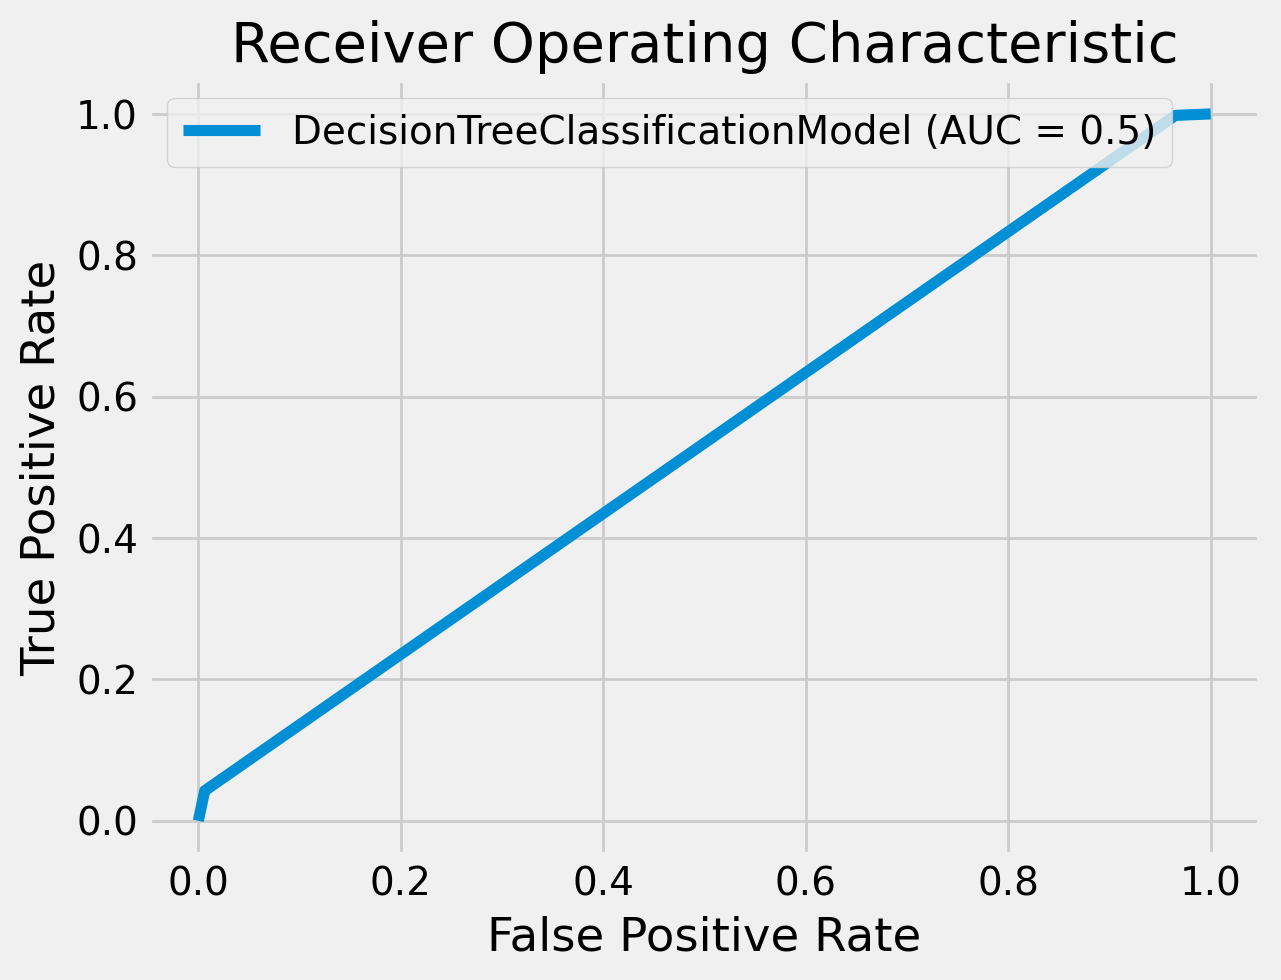

In [64]:
plotROC(dtModel_tf_idf, pred_dt_tf, AUC_dt_tf)

### Train DT on CountVectorizer Features

In [65]:
%%time
dtModel_cv = dt.fit(train_cv)
pred_dt_cv = dtModel_cv.transform(val_cv)

Wall time: 51min 30s


### Validate DT model on CountVectorizer Features 

In [66]:
accuracy_dt_cv = eval_accuracy.evaluate(pred_dt_cv)
precision_dt_cv = eval_precision.evaluate(pred_dt_cv)
recall_dt_cv = eval_recall.evaluate(pred_dt_cv)
f1score_dt_cv = eval_f1.evaluate(pred_dt_cv)
AUC_dt_cv = evaluator.evaluate(pred_dt_cv)

In [67]:
print('accuracy of DT on CountVectorizer Features: ',accuracy_dt_cv)
print('precision of DT on CountVectorizer Features: ',precision_dt_cv)
print('recall of DT on CountVectorizer Features: ',recall_dt_cv)
print('f1 score of DT on CountVectorizer Features: ',f1score_dt_cv)
print('AUC of DT on CountVectorizer Features: ',AUC_dt_cv)

accuracy of DT on CountVectorizer Features:  0.5256996419918732
precision of DT on CountVectorizer Features:  0.6854710328998881
recall of DT on CountVectorizer Features:  0.5256996419918732
f1 score of DT on CountVectorizer Features:  0.385934184711923
AUC of DT on CountVectorizer Features:  0.4986444898085306


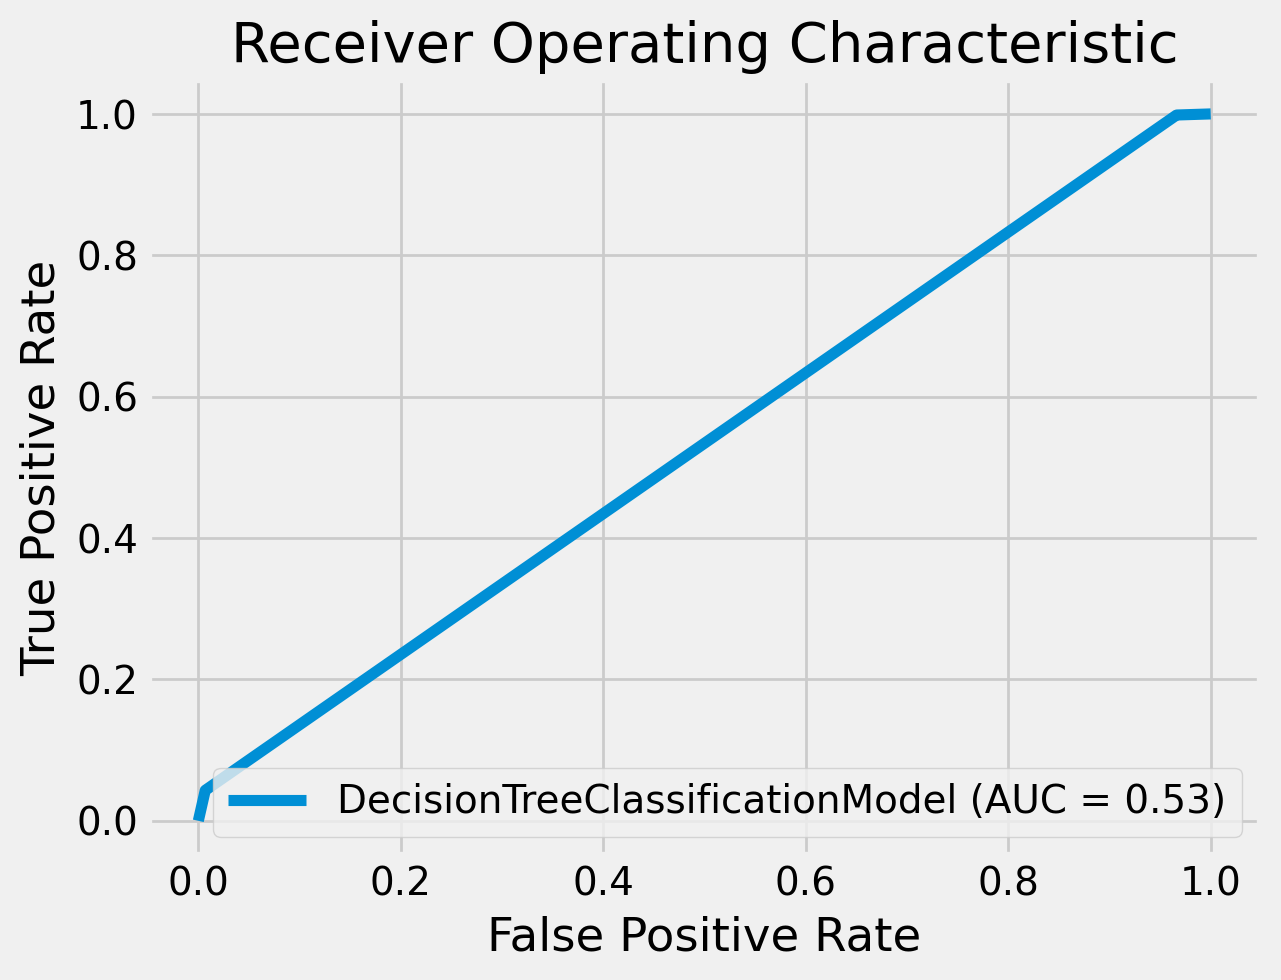

In [68]:
plotROC(dtModel_cv, pred_dt_cv, AUC_nv_cv)